In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [8]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [9]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

In [10]:
# meta preparation

In [11]:
meta_df = pd.read_csv(
    "../../gisaid/england_lond_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/england_lond.fasta"), total=24778)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

 89%|████████▉ | 22001/24778 [01:44<00:13, 210.67it/s]


In [14]:
# Meta description

In [15]:
print(len(
    meta_df.loc[
        meta_df["percN"] == 0.
    ]
))
print(len(
    meta_df.loc[
        meta_df["percN"] < 0.001
    ]
))

2885
3403


<AxesSubplot:xlabel='days', ylabel='Count'>

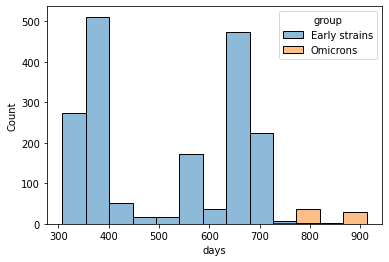

In [16]:
plot_df = meta_df.copy()
plot_df = plot_df.loc[
    (~plot_df["scorpio_call"].isna()) & \
    (plot_df["percN"] == 0.)
]

plot_df["group"] = "Early strains"
plot_df.loc[
    plot_df["scorpio_call"].str.contains("Omicron"),
    "group"
] = "Omicrons"

sns.histplot(
    x="days",
    hue="group",
    data=plot_df.loc[
        plot_df["percN"] == 0.
    ][["days", "group"]]
)

MannwhitneyuResult(statistic=24286.5, pvalue=8.349255199874135e-18)


<AxesSubplot:xlabel='length', ylabel='Count'>

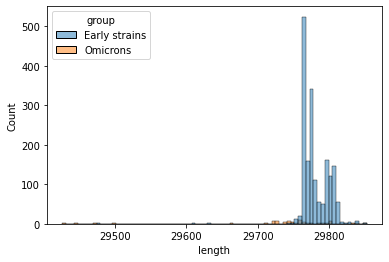

In [17]:
print(mannwhitneyu(
    plot_df.loc[
        plot_df["group"] == "Omicrons",
        "length"].to_list(),
    plot_df.loc[
        plot_df["group"] == "Early strains",
        "length"].to_list()
))

sns.histplot(
    x="length",
    hue="group",
    data=plot_df
)

In [18]:
# Berlin VOC's description

In [19]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    (meta_df["percN"] == 0.) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()

<ipython-input-19-16c02205110c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [20]:
STRAINS[:1]

['hCoV-19/England/LOND-1250FF0/2020|2020-11-09|2020-11-30']

In [21]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])
print(len(meta_df))

2020-01-01 00:00:00
2022-08-15 00:00:00
22001


In [22]:
print(meta_df.loc[STRAINS].iloc[0]["date"])
print(meta_df.loc[STRAINS].iloc[-1]["date"])

2020-11-09 00:00:00
2022-07-04 00:00:00


In [23]:
meta_df = meta_df.loc[STRAINS]

In [24]:
print(meta_df["scorpio_call"].value_counts().sum())
meta_df["scorpio_call"].value_counts()

1855


Alpha (B.1.1.7-like)      854
Delta (AY.4-like)         552
Delta (B.1.617.2-like)    216
Delta (AY.4.2-like)       161
Omicron (BA.2-like)        27
Omicron (BA.1-like)        23
Omicron (BA.5-like)        13
Omicron (BA.4-like)         5
B.1.1.7-like+E484K          1
A.23.1-like                 1
B.1.1.318-like              1
Omicron (XE-like)           1
Name: scorpio_call, dtype: int64

In [25]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

In [26]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts()

1786


scorpio_call          
Alpha (B.1.1.7-like)      854
Delta (AY.4-like)         552
Delta (B.1.617.2-like)    216
Delta (AY.4.2-like)       161
A.23.1-like                 1
B.1.1.318-like              1
B.1.1.7-like+E484K          1
dtype: int64

In [27]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts()

69


scorpio_call       
Omicron (BA.2-like)    27
Omicron (BA.1-like)    23
Omicron (BA.5-like)    13
Omicron (BA.4-like)     5
Omicron (XE-like)       1
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


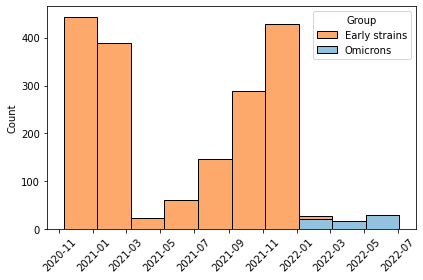

In [28]:
plot_df = meta_df.loc[STRAINS].copy()

plot_df.loc[
    plot_df["group"] == "first",
    "group"
] = "Early strains"

plot_df.loc[
    plot_df["group"] == "second",
    "group"
] = "Omicrons"

plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain",
    "date": "Date",
    "group": "Group"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.5,0.6, 1)),
    top(np.linspace(0.5, 0.6, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.histplot(
    x="Date",
    hue="Group",
    multiple="stack",
    data=plot_df,
    bins=10,
    palette=cmap.colors
)
plt.ylabel("Count")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("../../pictures/berlin-strains.png", dpi=500)

MannwhitneyuResult(statistic=98947.5, pvalue=8.349255199874135e-18)
29779.871780515117 29738.985507246376


<AxesSubplot:xlabel='length', ylabel='Probability'>

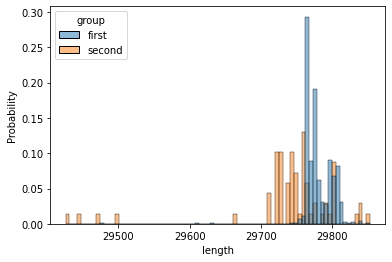

In [29]:
print(mannwhitneyu(
    meta_df.loc[meta_df["group"] == "first"]["length"].to_list(),
    meta_df.loc[meta_df["group"] == "second"]["length"].to_list()
))
print(
    meta_df.loc[meta_df["group"] == "first"]["length"].mean(),
    meta_df.loc[meta_df["group"] == "second"]["length"].mean()
)
# sns.scatterplot(x="length", y="percN", hue="group", alpha=0.5, data=meta_df)
sns.histplot(
    x="length",
    hue="group",
    alpha=0.5,
    data=meta_df,
    stat="probability",
    common_norm=False,
)

In [30]:
# binding regions

In [32]:
rdf = pd.read_csv(f"../../results/england_lond/seed.csv", sep=";", index_col=0)
rdf.index = rdf.index.str.lstrip(">")
rdf["strain"] = rdf.index

# LUAD analysis

In [33]:
# expressed miRNAs

In [34]:
miRNA_df = pd.read_csv("../../miRNA/expressed_LUAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [35]:
mrdf = rdf.loc[STRAINS][MIMATS]
mrdf["strain"] = mrdf.index

In [36]:
# region count df

In [37]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 471.21it/s]


In [38]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 729.22it/s]


In [39]:
# average count of binding regions

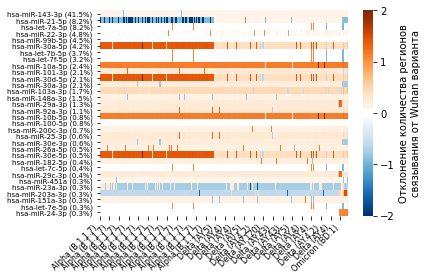

In [40]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (30331 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-2, -1, 0, 1, 2],
        "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
# plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

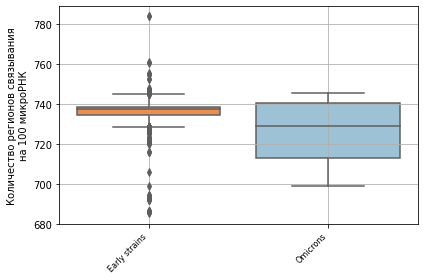

In [41]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 1)),
    top(np.linspace(0.6, 0.9, 1)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    palette=cmap.colors,
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
    [680, 700, 720, 740, 760, 780]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

# ax.get_legend().remove()
plt.grid()
plt.tight_layout()
# plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [42]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Early strains", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list()
))

MannwhitneyuResult(statistic=80837.0, pvalue=1.0517264643662027e-05)


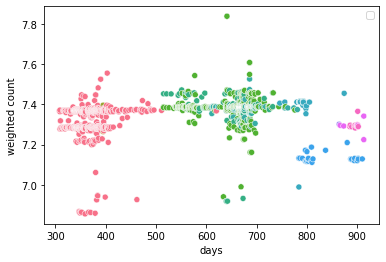

In [43]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days"
]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

sns.scatterplot(
    x="days",
    y="weighted count",
    data=plot_df, # .loc[plot_df["group"] == "Omicrons"],
    hue="Strain"
)
plt.legend([])

In [44]:
# seed region distribution

In [45]:
seed_df = rdf.copy()
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [46]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [47]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in tqdm.tqdm(MIMATS):
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name
        append_df.loc[:, "miRNA"] = mimat
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

100%|██████████| 32/32 [00:02<00:00, 15.82it/s]


,group,seed,miRNA
0,first,9860,MIMAT0000062
1,first,12449,MIMAT0000062
2,first,19060,MIMAT0000062
3,first,9860,MIMAT0000062
4,first,12449,MIMAT0000062


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


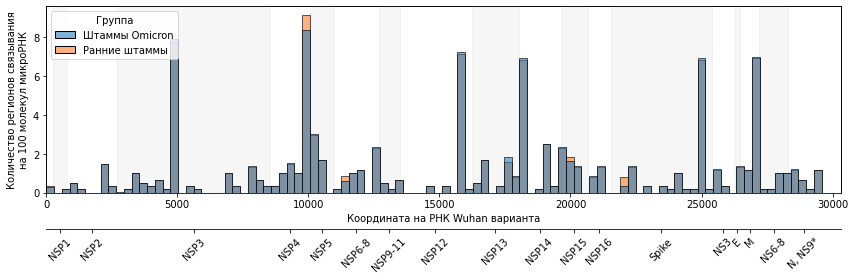

In [48]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


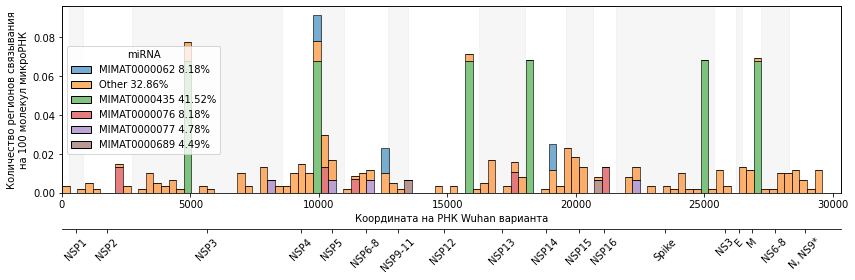

In [49]:
plot_df = result_df.loc[result_df["group"] == "first"]

mimats = miRNA_df.sort_values(
    by=["CPM"], ascending=False
).iloc[:5]["MIMAT"].to_list()

plot_df.loc[~plot_df["miRNA"].isin(mimats), "miRNA"] = \
    f"Other {100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%"
for mimat in mimats:
    plot_df.loc[plot_df["miRNA"] == mimat, "miRNA"] = \
        f"{mimat} {miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%"
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4
    
sns.histplot(
    x="seed",
    hue="miRNA",
    data=plot_df,
    stat="probability",
    multiple="stack",
    bins=100,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

# ax.set_yticks(
#     [i / 100 for i in range(0, 9, 2)],
#     labels=[i for i in range(0, 9, 2)]
# )

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [50]:
# proteins contribution

In [51]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [52]:
result_df.sort_values(by=["first weighted"], ascending=False)

,region,length,first weighted,second weighted,first count,second count,p-value,fdr
29,RNA,30331,7.221782,7.122487,314.815789,312.927536,8.482363e-08,3.635298e-07
3,NSP3,5835,1.062197,1.071099,50.529675,51.666667,6.628539e-22,4.971405e-21
17,Spike,3822,0.866215,0.835610,43.418253,42.347826,1.946846e-06,7.300671e-06
4,NSP4,1500,0.858367,0.796967,22.010078,20.043478,1.398715e-84,1.398715e-83
14,NSP14,1581,0.749493,0.749474,21.984323,22.000000,4.789007e-01,8.979388e-01
12,NSP12,2769,0.521433,0.521948,11.006159,11.000000,9.490136e-01,1.000000e+00
21,NS6,186,0.413761,0.409139,0.996641,0.985507,1.392688e-01,2.984331e-01
13,NSP13,1803,0.387345,0.403325,30.830347,31.000000,2.841139e-04,8.523417e-04
15,NSP15,1038,0.337071,0.319567,19.973684,18.666667,1.650068e-153,4.950204e-152
5,NSP5,918,0.326231,0.325997,13.983763,13.956522,9.948568e-01,1.000000e+00


In [53]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP15 & 1038 & 33.71 & 31.96 & 0.0000 \\
\hline
& N & 1260 & 19.29 & 19.64 & 0.0000 \\
\hline
& NSP4 & 1500 & 85.84 & 79.70 & 0.0000 \\
\hline
& NSP3 & 5835 & 106.22 & 107.11 & 0.0000 \\
\hline
& 5P & 265 & 2.48 & 2.31 & 0.0000 \\
\hline
& NS8 & 366 & 13.90 & 13.98 & 0.0000 \\
\hline
& RNA & 30331 & 722.18 & 712.25 & 0.0000 \\
\hline
& Spike & 3822 & 86.62 & 83.56 & 0.0000 \\
\hline
& NS9b & 294 & 6.73 & 6.93 & 0.0003 \\
\hline
& NSP13 & 1803 & 38.73 & 40.33 & 0.0009 \\
\hline
& 3P & 798 & 7.57 & 7.64 & 0.0022 \\
\hline
& NSP6 & 870 & 15.42 & 13.89 & 0.0062 \\
\hline


In [54]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted            fdr
15  NSP15   1038       33.707092        31.956664  4.950204e-152
25      N   1260       19.286391        19.638842  2.069384e-114
4    NSP4   1500       85.836685        79.696692   1.398715e-83
3    NSP3   5835      106.219682       107.109943   4.971405e-21
0      5P    265        2.483184         2.306062   2.353659e-18
24    NS8    366       13.903862        13.977542   1.651043e-15
29    RNA  30331      722.178249       712.248679   3.635298e-07
17  Spike   3822       86.621456        83.561041   7.300671e-06
26   NS9b    294        6.731120         6.933822   2.937674e-04
13  NSP13   1803       38.734454        40.332459   8.523417e-04
28     3P    798        7.569740         7.640567   2.171304e-03
6    NSP6    870       15.417192        13.888843   6.223452e-03


In [55]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.361430
second weighted    7.264279
dtype: float64

In [56]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     314.815789
second count    312.927536
dtype: float64

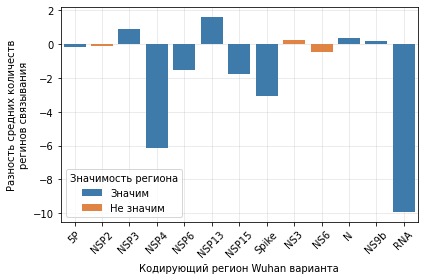

In [57]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
# plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)

# COAD analysis

In [58]:
# expressed miRNAs

In [59]:
miRNA_df = pd.read_csv("../../miRNA/expressed_COAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [60]:
mrdf = rdf.loc[STRAINS][MIMATS]
mrdf["strain"] = mrdf.index

In [61]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 474.25it/s]


In [62]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 723.71it/s]


In [63]:
# average count of binding regions

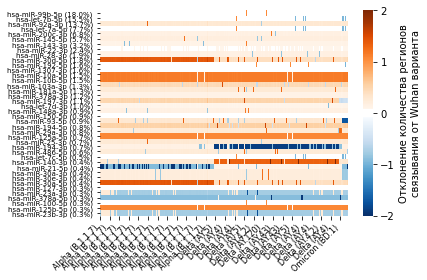

In [64]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (30331 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-2,
    vmax=2,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-2, -1, 0, 1, 2],
        "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
# plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

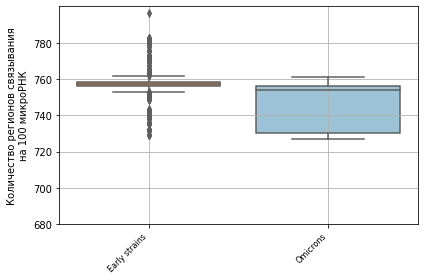

In [65]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 1)),
    top(np.linspace(0.6, 0.9, 1)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    palette=cmap.colors,
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
    [680, 700, 720, 740, 760, 780]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

# ax.get_legend().remove()
plt.grid()
plt.tight_layout()
# plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [66]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Early strains", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list()
))

MannwhitneyuResult(statistic=106299.0, pvalue=1.347567191301208e-24)


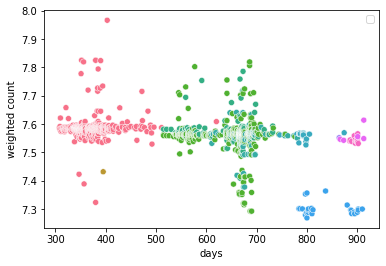

In [67]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days"
]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Early strains"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 30331 / plot_df["length"]

sns.scatterplot(
    x="days",
    y="weighted count",
    data=plot_df, # .loc[plot_df["group"] == "Early strains"],
    hue="Strain"
)
plt.legend([])

In [68]:
# seed region distribution

In [69]:
seed_df = rdf.copy()
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [70]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [71]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in tqdm.tqdm(MIMATS):
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name 
        append_df.loc[:, "miRNA"] = mimat
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

100%|██████████| 40/40 [00:02<00:00, 17.62it/s]


,group,seed,miRNA
0,first,9860,MIMAT0000062
1,first,12449,MIMAT0000062
2,first,19060,MIMAT0000062
3,first,9860,MIMAT0000062
4,first,12449,MIMAT0000062


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


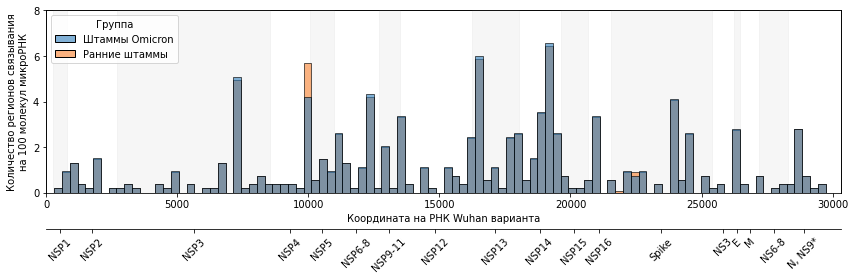

In [72]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


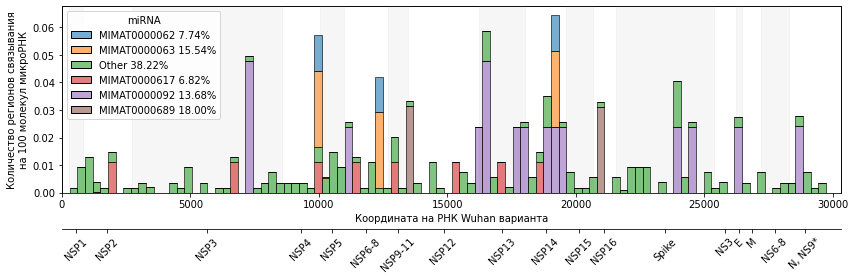

In [73]:
plot_df = result_df.loc[result_df["group"] == "first"]

mimats = miRNA_df.sort_values(
    by=["CPM"], ascending=False
).iloc[:5]["MIMAT"].to_list()

plot_df.loc[~plot_df["miRNA"].isin(mimats), "miRNA"] = \
    f"Other {100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%"
for mimat in mimats:
    plot_df.loc[plot_df["miRNA"] == mimat, "miRNA"] = \
        f"{mimat} {miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%"
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4
    
sns.histplot(
    x="seed",
    hue="miRNA",
    data=plot_df,
    stat="probability",
    multiple="stack",
    bins=100,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

# ax.set_yticks(
#     [i / 100 for i in range(0, 9, 2)],
#     labels=[i for i in range(0, 9, 2)]
# )

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [74]:
# proteins contribution

In [75]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [76]:
result_df.sort_values(by=["first weighted"], ascending=False)

,region,length,first weighted,second weighted,first count,second count,p-value,fdr
29,RNA,30331,7.434661,7.309775,386.028555,380.724638,4.526069e-28,3.394552e-27
13,NSP13,1803,0.999401,1.000912,36.809630,37.014493,1.715037e-04,7.350159e-04
14,NSP14,1581,0.939383,0.940710,28.972004,29.000000,2.829641e-01,5.659282e-01
3,NSP3,5835,0.913576,0.910032,66.011198,65.623188,1.143767e-16,6.862602e-16
17,Spike,3822,0.906595,0.880586,55.491601,53.000000,4.947962e-48,4.947962e-47
4,NSP4,1500,0.483380,0.390220,19.004479,17.826087,1.806420e-71,2.709629e-70
6,NSP6,870,0.338296,0.338774,17.510638,17.333333,9.263765e-01,9.583205e-01
12,NSP12,2769,0.328131,0.327739,22.997760,22.942029,2.290064e-02,7.633548e-02
16,NSP16,894,0.305509,0.305788,13.995521,13.985507,4.097919e-01,7.683599e-01
2,NSP2,1914,0.289110,0.288605,20.998880,20.985507,5.703725e-01,9.506208e-01


In [77]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP15 & 1038 & 13.08 & 12.59 & 0.0000 \\
\hline
& NSP4 & 1500 & 48.34 & 39.02 & 0.0000 \\
\hline
& Spike & 3822 & 90.66 & 88.06 & 0.0000 \\
\hline
& RNA & 30331 & 743.47 & 730.98 & 0.0000 \\
\hline
& NSP3 & 5835 & 91.36 & 91.00 & 0.0000 \\
\hline
& NSP1 & 540 & 9.11 & 9.08 & 0.0002 \\
\hline
& NSP13 & 1803 & 99.94 & 100.09 & 0.0007 \\
\hline
& NS9b & 294 & 4.37 & 4.43 & 0.0202 \\
\hline


In [78]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted            fdr
15  NSP15   1038       13.082752        12.592548  2.362479e-159
4    NSP4   1500       48.338047        39.022038   2.709629e-70
17  Spike   3822       90.659519        88.058551   4.947962e-47
29    RNA  30331      743.466115       730.977461   3.394552e-27
3    NSP3   5835       91.357649        91.003176   6.862602e-16
1    NSP1    540        9.107548         9.083584   1.642772e-04
13  NSP13   1803       99.940107       100.091190   7.350159e-04
26   NS9b    294        4.367294         4.433568   2.017362e-02


In [79]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.662261
second weighted    7.538155
dtype: float64

In [80]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     386.028555
second count    380.724638
dtype: float64

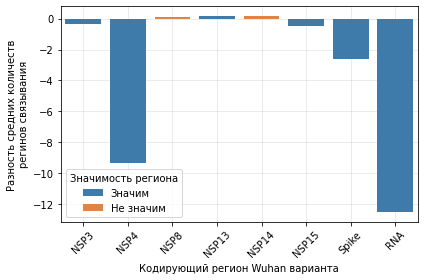

In [81]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
# plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)